In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

df = pd.read_csv('NSE-TATAGLOBAL.csv')

df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


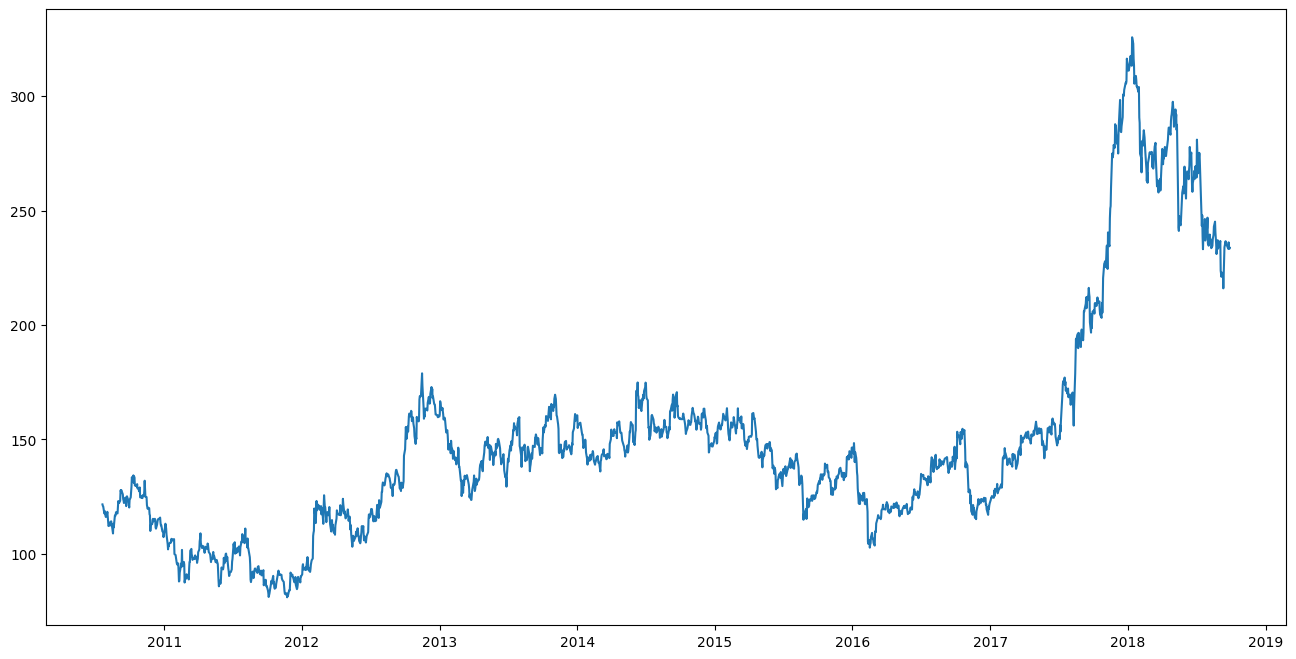

In [2]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [7]:
!pip install fastai

ERROR: Could not find a version that satisfies the requirement fastai.tabular (from versions: none)
ERROR: No matching distribution found for fastai.tabular


In [16]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

data = df.sort_index(ascending=True, axis=0)

new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

from fastai.tabular.core import add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

<ipython-input-16-772b3e32f774>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_data['Date'][i] = data['Date'][i]
<ipython-input-16-772b3e32f774>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_data['Close'][i] = data['Close'][i]
/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], inf

In [21]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [22]:
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [23]:
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

50.42850799431636

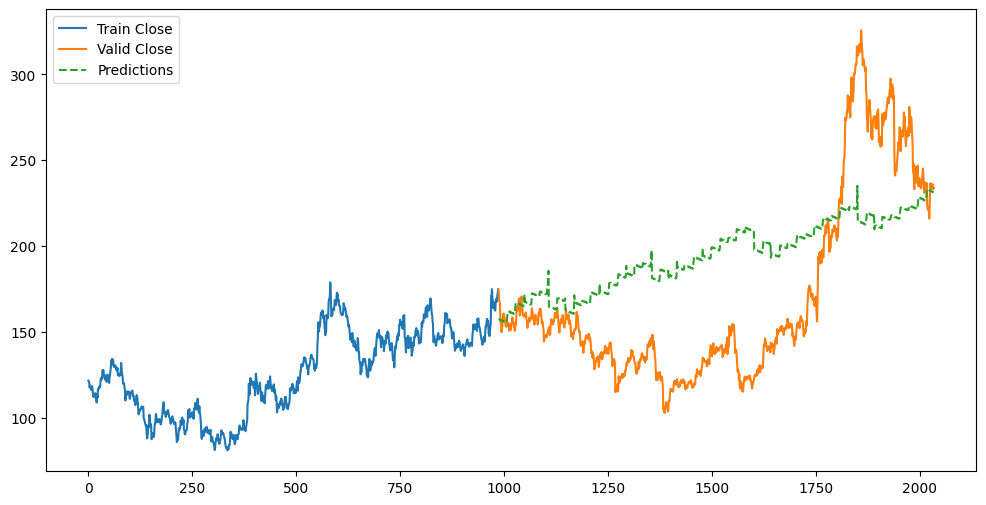

In [25]:
# Assuming valid and train are slices, create copies to avoid SettingWithCopyError
valid = new_data[987:].copy()
train = new_data[:987].copy()

# Add the 'Predictions' column with default value and then assign the predictions
valid.loc[:, 'Predictions'] = 0
valid.loc[:, 'Predictions'] = preds

# Set the indices for valid and train DataFrames
valid.index = new_data[987:].index
train.index = new_data[:987].index

# Plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label='Train Close')
plt.plot(valid['Close'], label='Valid Close')
plt.plot(valid['Predictions'], label='Predictions', linestyle='--')
plt.legend()
plt.show()


LSTM Predictions

In [26]:

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

<ipython-input-26-fd40126fce89>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_data['Date'][i] = data['Date'][i]
<ipython-input-26-fd40126fce89>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_data['Close'][i] = data['Close'][i]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


927/927 - 28s - 30ms/step - loss: 0.0012
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


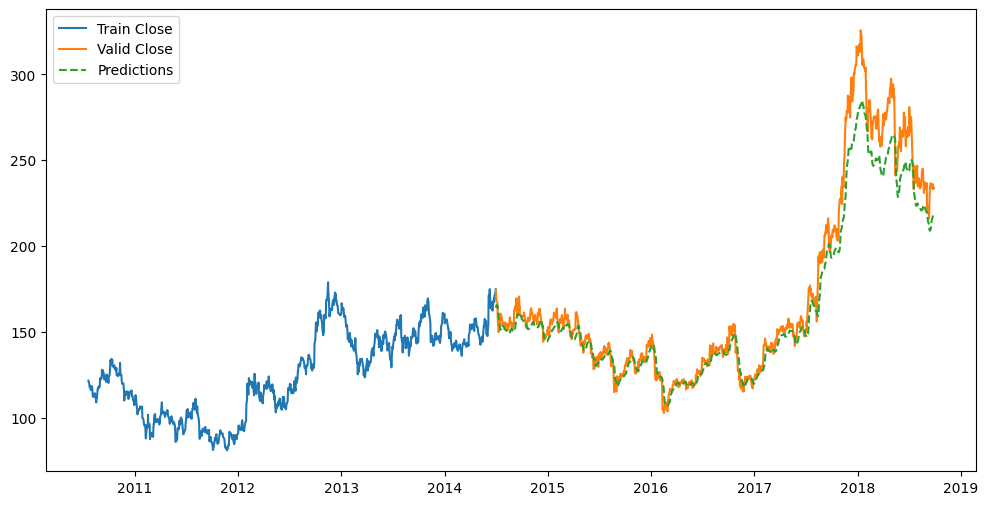

In [28]:
train = new_data[:987].copy()
valid = new_data[987:].copy()

# Use .loc for assignment
valid.loc[:, 'Predictions'] = closing_price

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label='Train Close')
plt.plot(valid['Close'], label='Valid Close')
plt.plot(valid['Predictions'], label='Predictions', linestyle='--')
plt.legend()
plt.show()

CNN Time Series Forecasting

In [30]:
!pip install keras

In [32]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D


In [33]:
# split a univariate sequence into samples
def split_sequence(sequence, steps):
  X, y = list(), list()
  for start in range(len(sequence)):
    # define the end index of the sequence
    end_index = start + steps
    # to check if end_index stays in the allowable limit
    if end_index > len(sequence)-1:
      break
    # extract input and output parts of the sequence
    sequence_x, sequence_y = sequence[start : end_index], sequence[end_index]
    X.append(sequence_x)
    y.append(sequence_y)
  return array(X), array(y)

In [34]:
raw_sequence = [100, 110, 120, 130, 140, 150 ,160, 170, 180 ,190]

# choose a number of time steps
steps = 3

# split into samples
X, y = split_sequence(raw_sequence, steps)

print("*"*30)
print("The input raw sequence on which we will test our CNN model")
print(raw_sequence)
print("*"*30)
print("The features (X) ,lagged values of time series, for our CNN model")
print(X)
print("*"*30)
print("The respective observed values (y) of the sequence for training in CNN model")
print(y)
print("*"*30)

******************************
The input raw sequence on which we will test our CNN model
[100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
******************************
The features (X) ,lagged values of time series, for our CNN model
[[100 110 120]
 [110 120 130]
 [120 130 140]
 [130 140 150]
 [140 150 160]
 [150 160 170]
 [160 170 180]]
******************************
The respective observed values (y) of the sequence for training in CNN model
[130 140 150 160 170 180 190]
******************************


In [35]:
features = 1
X = X.reshape((X.shape[0], X.shape[1], features))

print("After reshaping , the shape of input X")
print(X.shape)
print("*"*30)
print("*"*30)
print("The final form of input feature matrix X")
print(X)
print("*"*30)
print("*"*30)
print("Feature matrix X is ready for input to CNN model.We have used feature engineering"
    +"to convert a sequence to matrix with image matrix shape to find patterns in sequence")
print("*"*30)

After reshaping , the shape of input X
(7, 3, 1)
******************************
******************************
The final form of input feature matrix X
[[[100]
  [110]
  [120]]

 [[110]
  [120]
  [130]]

 [[120]
  [130]
  [140]]

 [[130]
  [140]
  [150]]

 [[140]
  [150]
  [160]]

 [[150]
  [160]
  [170]]

 [[160]
  [170]
  [180]]]
******************************
******************************
Feature matrix X is ready for input to CNN model.We have used feature engineeringto convert a sequence to matrix with image matrix shape to find patterns in sequence
******************************


In [36]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(steps,
features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.fit(X, y, epochs=10000, verbose=0)

In [38]:
x_input = array([ 170, 180, 190 ])
x_input = x_input.reshape((1, steps, features))
y_pred = model.predict(x_input, verbose=0)
print("*"*30)
print(f"The next predicted value for the sequence {raw_sequence} is")
print(y_pred)
print("*"*30)


******************************
The next predicted value for the sequence [100, 110, 120, 130, 140, 150, 160, 170, 180, 190] is
[[200.0049]]
******************************


In [39]:
from numpy import array
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in,
n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(105, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=7000, verbose=0)

# demonstrate prediction
x_input = array([ 70,80, 90 ])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.54715 114.76036]]


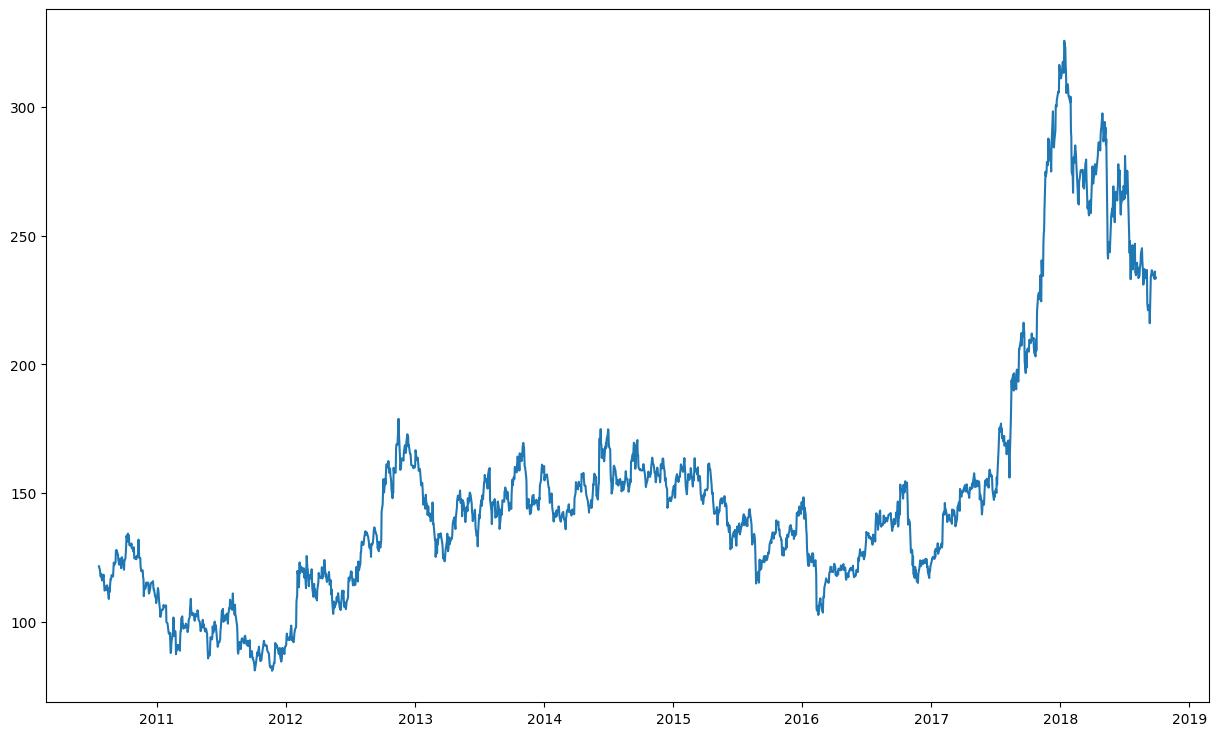

In [40]:
plt.figure(figsize=(15,9))
plt.plot(df['Close'], label='Close Price history')

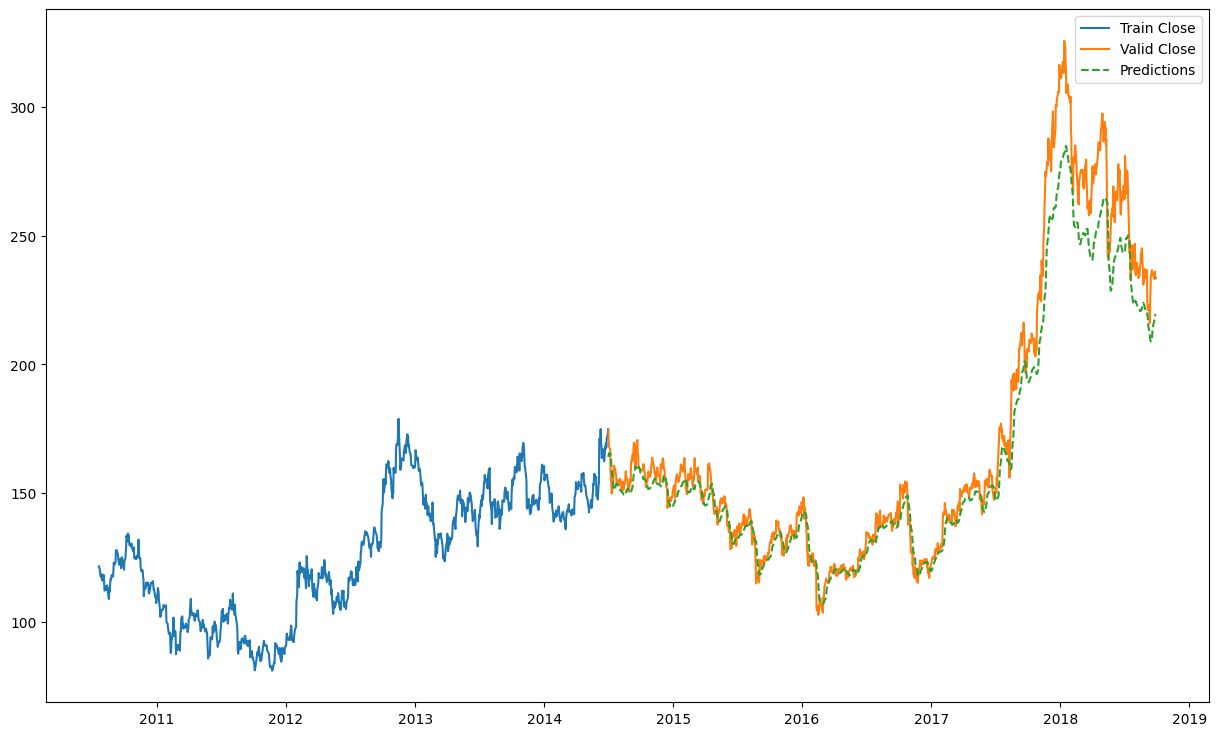

In [42]:
train = new_data[:987].copy()
valid = new_data[987:].copy()

# Use .loc for assignment
valid.loc[:, 'Predictions'] = closing_price

# Plot the data
plt.figure(figsize=(15, 9))
plt.plot(train['Close'], label='Train Close')
plt.plot(valid['Close'], label='Valid Close')
plt.plot(valid['Predictions'], label='Predictions', linestyle='--')
plt.legend()
plt.show()